# Test alignment parsing by `Targets`
This Jupyter notebook is designed to test parsing of alignments by `Targets`.

## Import Python modules

In [1]:
import contextlib
import os
import random
import re
import tempfile

from IPython.display import display

import pandas as pd

import alignparse.minimap2
import alignparse.targets

## Set up `Targets`
Read in the RecA target used in the notebook examples:

There is just one target: ['RecA_PacBio_amplicon']
It has the following features: ['termini5', 'gene', 'spacer', 'barcode', 'termini3', 'variant_tag5', 'variant_tag3']


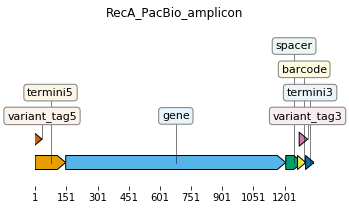

In [2]:
targetfile = '../notebooks/input_files/recA_amplicon.gb'

targets = alignparse.targets.Targets(seqsfile=targetfile, allow_extra_features=True)

print(f"There is just one target: {targets.target_names}")
target = targets.targets[0]

print(f"It has the following features: {target.feature_names}")

_ = targets.plot()

Location of features in 0-indexed scheme:

In [3]:
for feature in target.features:
    print(feature.name, feature.start, feature.end)

termini5 0 147
gene 147 1206
spacer 1206 1285
barcode 1285 1303
termini3 1303 1342
variant_tag5 32 33
variant_tag3 1310 1311


## Make some queries
We make some query sequences that we will align against the target.
The name of each query is a description of all ways that it differs from target:

In [4]:
random.seed(1)  # for reproducible output
nts = 'ACGT'  # valid nucleotides

def randseq(length):
    """Random nucleotide sequence of given length."""
    return ''.join(random.choices(nts, k=length))

def mutseq(wtseq):
    """Random mutant sequence from a wildtype sequence."""
    return ''.join(random.choice([nt for nt in nts if nt != wt]) for wt in wtseq)

def get_wt_query(target, ambiguous_features=('barcode', 'variant_tag5', 'variant_tag3')):
    """`(description, seq)` for wildtype query, ambiguous features assigned."""
    seq = target.seq
    description = []
    for fname in ambiguous_features:
        f = target.get_feature(fname)
        fseq = randseq(f.length)
        seq = seq[: f.start] + fseq + seq[f.end:]
        description.append(f"{f.name}={fseq}")
    assert len(seq) == len(target.seq)
    assert re.fullmatch(f"[{nts}]+", seq)
    return ','.join(description), seq

queries = []

# get two random (unmappable) queries
queries.append(('unmapped_1', randseq(target.length)))
queries.append(('unmapped_2', randseq(target.length // 2)))

# get a fully wildtype query
queries.append(get_wt_query(target))

# query with query clipping at both ends and a codon substitution in gene
desc, seq = get_wt_query(target)
# add substitution to gene
gene = target.get_feature('gene')
geneseq = gene.seq
mutstart = 6
mutlength = 3
mutcodon = mutseq(gene.seq[mutstart: mutstart + mutlength])
sub_desc = []
for i in range(mutlength):
    wt = geneseq[i + mutstart]
    mut = mutcodon[i]
    sub_desc.append(f"{wt}{mutstart + i}{mut}")
    geneseq = geneseq[: mutstart + i] + mut + geneseq[mutstart + i + 1:]
seq = seq[: gene.start] + geneseq + seq[gene.end:]
desc += f",gene_{'-'.join(sub_desc)}"
# add clipping
desc += ',query_clip5=9'
seq = randseq(9) + seq
desc += ',query_clip3=7'
seq += randseq(7)
# add to list of queries
queries.append((desc, seq))

# query with a deletion in gene and in insertion in spacer
desc, seq = get_wt_query(target)
delstart = 7
dellength = 15
geneseq = gene.seq[: delstart] + gene.seq[delstart + dellength:]
spacer = target.get_feature('spacer')
insstart = 4
ins = 'GATCTA'
spacerseq = spacer.seq[: insstart] + ins + spacer.seq[insstart:]
seq = seq[: gene.start] + geneseq + seq[gene.end: spacer.start] + spacerseq + seq[spacer.end:] 
desc += f",gene_del{delstart}to{delstart + dellength}"
desc += f",spacer_ins{insstart}{ins}"
queries.append((desc, seq))

# query with deletion spanning gene and spacer
desc, seq = get_wt_query(target)
delstartgene = gene.length - 7
delendgene = delstartgene + 7
geneseq = gene.seq[: delstartgene]
delendspacer = 9
spacerseq = spacer.seq[delendspacer:]
seq = seq[: gene.start] + geneseq + spacerseq + seq[spacer.end:]
desc += f",gene_del{delstartgene}to{delendgene},spacer_del1to{delendspacer}"
queries.append((desc, seq))

# query with insertion at boundary of gene and spacer, note how
# it is assigned as being at end of gene
desc, seq = get_wt_query(target)
ins = randseq(14)
seq = seq[: gene.end] + ins + seq[spacer.start:]
desc += f",gene_ins{gene.length}{ins}"
queries.append((desc, seq))

# query with target clipping at both ends
desc, seq = get_wt_query(target)
target_clip5 = target.get_feature('termini5').length + 4
target_clip3 = 2
seq = seq[target_clip5: -target_clip3]
desc = desc.split(',')
desc = ','.join([desc[0], 'variant_tag5=None', desc[2]])
desc += f",target_clip5={target_clip5},target_clip3={target_clip3}"
desc += ',termini5=None,gene=<clip4>,termini3=<clip3>'
queries.append((desc, seq))

## Align the queries to the target

In [5]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

with contextlib.ExitStack() as stack:
    
    # write queries to FASTA file
    queryfile = tempfile.NamedTemporaryFile('r+', suffix='.fasta')
    queryfile.write('\n'.join(f">{desc}\n{seq}" for desc, seq in queries))
    queryfile.flush()
    
    # align the queries to the target
    alignmentfile = tempfile.NamedTemporaryFile('r+', suffix='.sam')
    targets.align(queryfile.name, alignmentfile.name, mapper)
    
    # get the alignment cs data frame
    alignments_cs = targets.parse_alignment_cs(alignmentfile)

## Check results of `Targets.parse_alignment_cs`
We now check if the feature-specific `cs` strings returned by `Targets.parse_alignment_cs` are correct.

We expect there to be alignments for just our one target plus the number of unmapped reads:

In [6]:
sorted(alignments_cs.keys()) == [target.name, 'unmapped']

True

Make sure the number of unmapped queries equals the number we passed in:

In [7]:
unmapped_queries = [(desc, query) for desc, query in queries if 'unmapped' in desc]
len(unmapped_queries) == alignments_cs['unmapped']

True

Make sure we get the expected queries mapped to our target:

In [8]:
mapped_queries = [tup for tup in queries if tup not in unmapped_queries]
len(mapped_queries) == len(alignments_cs[target.name])

True

Now we look manually at whether we got the expected `cs` strings for features.
We do **not** programatically check that these are correct based on how the queries were created (that will be done below using the more human-readable results from `Targets.parse_alignment`).
But the `cs` strings below have been examined manually, and they appear to be correct:

In [9]:
with pd.option_context('display.max_colwidth', -1):
    display(alignments_cs[target.name])

,query_name,query_clip5,query_clip3,target_clip5,target_clip3,termini5,gene,spacer,barcode,termini3,variant_tag5,variant_tag3
0,"barcode=CTAACTCGAGCTGCAATG,variant_tag5=A,variant_tag3=T",0,0,0,0,:32*na:114,:1059,:79,*nc*nt*na*na*nc*nt*nc*ng*na*ng*nc*nt*ng*nc*na*na*nt*ng,:7*nt:31,*na,*nt
1,"barcode=ACTAAAACCCACCGCGCT,variant_tag5=A,variant_tag3=C,gene_A6G-T7A-C8G,query_clip5=9,query_clip3=7",9,7,0,0,:32*na:114,:6*ag*ta*cg:1050,:79,*na*nc*nt*na*na*na*na*nc*nc*nc*na*nc*nc*ng*nc*ng*nc*nt,:7*nc:31,*na,*nc
2,"barcode=GTTACGACACGTTATTTC,variant_tag5=T,variant_tag3=C,gene_del7to22,spacer_ins4GATCTA",0,0,0,0,:32*nt:114,:7-tcgacgaaaacaaac:1037,:4+gatcta:75,*ng*nt*nt*na*nc*ng*na*nc*na*nc*ng*nt*nt*na*nt*nt*nt*nc,:7*nc:31,*nt,*nc
3,"barcode=TAGTCTGTATCATAACTT,variant_tag5=A,variant_tag3=T,gene_del1052to1059,spacer_del1to9",0,0,0,0,:32*na:114,:1052-agatttt,-taatcgtct:70,*nt*na*ng*nt*nc*nt*ng*nt*na*nt*nc*na*nt*na*na*nc*nt*nt,:7*nt:31,*na,*nt
4,"barcode=TACCCTTGCTAAGTACGC,variant_tag5=T,variant_tag3=G,gene_ins1059GGGATAGGAGACTA",0,0,0,0,:32*nt:114,:1059+gggataggagacta,:79,*nt*na*nc*nc*nc*nt*nt*ng*nc*nt*na*na*ng*nt*na*nc*ng*nc,:7*ng:31,*nt,*ng
5,"barcode=GCGTCACAAGTGCCGAAT,variant_tag5=None,variant_tag3=T,target_clip5=151,target_clip3=2,termini5=None,gene=<clip4>,termini3=<clip3>",0,0,151,2,None,<clip4>:1055,:79,*ng*nc*ng*nt*nc*na*nc*na*na*ng*nt*ng*nc*nc*ng*na*na*nt,:7*nt:29<clip2>,None,*nt
